In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
from pandas import read_csv
import math
import h5py
from keras.models import Sequential
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense, Activation, Dropout, LSTM
from scipy.signal import savgol_filter
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import scipy.stats as stats

In [2]:
import sys
sys.path.append('../../src')

In [3]:

import pandas 
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.components.result import Result 
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario, plot_fit
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from energiapy.aggregation.reduce_scenario import reduce_scenario, Clustermethod
from energiapy.aggregation.ahc import agg_hierarchial_elbow, IncludeAHC, Fit
from energiapy.aggregation.dtw import dynamic_warping, dynamic_warping_matrix, dynamic_warping_path, IncludeDTW
from energiapy.utils.math_utils import min_max, norm_constant
from energiapy.fitting.dist import fit
import matplotlib.pyplot as plt
from matplotlib import rc
from itertools import product
import pyomo.environ as pyo
import scipy
from pyomo.environ import Constraint
from energiapy.utils.scale_utils import scale_list
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.chance import chance_normal



In [4]:
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# years = [str(2017 + i) for i in range(7)]
# fuel_type = ['Biomass','Coal','Gas','Gas-CC','Hydro','Nuclear','Other','Solar','Wind']
# date_range = pandas.date_range(start='01-01-2017', end='03-31-2023')
# data = {year: {month: pandas.read_excel(f'IntGenbyFuel{year}.xlsx',sheet_name=month) for month in months} for year in years}
# df = pandas.concat(data[year][month] for year in years for month in months)
# filtered_df = df[(df['Fuel'] == 'Solar') & (df['Date'].isin(date_range))] #User input step
# columns =['Date','Fuel'] + [f'{i}:{j:02d}' for i in range(0,24) for j in range(0,60,15)]
# filtered_df = filtered_df[columns]
# k3 = pandas.DataFrame(columns=[filtered_df.columns[0], 'Timestamp', filtered_df.columns[1],'Values'])
# for i in range(filtered_df.shape[0]):
#     k2 = filtered_df.iloc[i, :]
#     row = pandas.DataFrame(np.zeros((96, 98)), columns=k2.index)
#     row.iloc[:, :2] = k2[k2.index[:2]].values
#     row['Timestamp'] = k2.index[2:]
#     row['Values'] = k2.values[2:]
#     k3 = pandas.concat([k3, row.loc[:, [k2.index[0],'Timestamp',k2.index[1],  'Values']]], ignore_index=True)
# k3['Datetime'] = pandas.to_datetime(k3['Date'].astype(str) + ' ' + k3['Timestamp'].astype(str))
# k3 = k3.drop(['Date', 'Timestamp','Fuel'], axis=1)
# k3 = k3.set_index('Datetime')

In [5]:
# dt = k3
# dt = dt.dropna()
# dt = dt.resample('D').mean()
# dt.plot()

NameError: name 'k3' is not defined

In [6]:
window_size = 50
polynomial_degree = 2
smoothed_data = savgol_filter(dt['Values'], window_size, polynomial_degree)
start = '2017-01-01'
end = '2023-03-31'
dates = pandas.date_range(start=start, end=end)
filtered_data = pandas.DataFrame(smoothed_data, index=dates, columns=['Values'])
filtered_data = np.log(filtered_data)

NameError: name 'dt' is not defined

<AxesSubplot: >

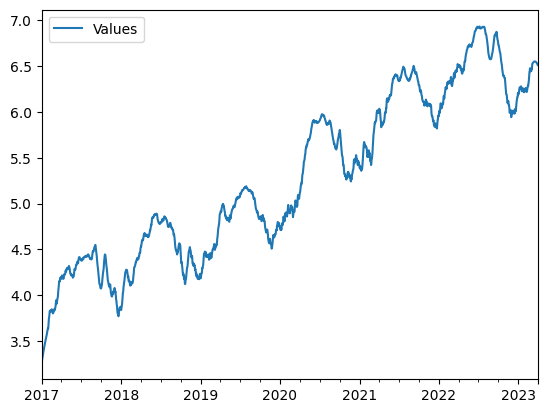

In [ ]:
filtered_data.plot()

In [ ]:
 # convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

all_y = filtered_data.values
dataset=all_y.reshape(-1, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets, 30% test data, 70% training data
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1, timestep 240
look_back = 150
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(5,return_sequences=True,activation='relu'), 
#     tf.keras.layers.Dropout(0.10),
#     tf.keras.layers.LSTM(50,return_sequences=True,activation='relu'),
#     tf.keras.layers.Dropout(0.10),
#     tf.keras.layers.LSTM(20),
# ])

learning_rate = 0.0005
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.3))
#model.add(LSTM(50, return_sequences=True, activation='relu'))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='mse', optimizer=optimizer)

# Train the model
history = model.fit(trainX, trainY, epochs=500, batch_size=240, verbose=1, validation_data=(testX, testY))
# model.save('C:\\Users\\Dell\\Desktop\\lstm_ci.h5')

Epoch 1/500
7/7 [==============================] - 4s 193ms/step - loss: 0.0773 - val_loss: 0.0420
Epoch 2/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0418 - val_loss: 0.0213
Epoch 3/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0164 - val_loss: 0.0470
Epoch 4/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0207 - val_loss: 0.0481
Epoch 5/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0136 - val_loss: 0.0081
Epoch 6/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0117 - val_loss: 0.0055
Epoch 7/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0108 - val_loss: 0.0250
Epoch 8/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0105 - val_loss: 0.0192
Epoch 9/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 10/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0083 - val_loss: 0.0175
Epoch 11/500
7/7 [

Epoch 164/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 165/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 7.8256e-04
Epoch 166/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 2.6503e-04
Epoch 167/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 168/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 169/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 170/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 3.8490e-04
Epoch 171/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 172/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 173/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0017 - val_l

Epoch 244/500
7/7 [==============================] - 0s 27ms/step - loss: 0.0017 - val_loss: 4.4259e-04
Epoch 245/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 246/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 247/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 248/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 249/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 250/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 2.0083e-04
Epoch 251/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 252/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 253/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss:

Epoch 324/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 8.7402e-04
Epoch 325/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 1.6655e-04
Epoch 326/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 2.9663e-04
Epoch 327/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 1.6205e-04
Epoch 328/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 5.5052e-04
Epoch 329/500
7/7 [==============================] - 0s 35ms/step - loss: 0.0012 - val_loss: 2.1040e-04
Epoch 330/500
7/7 [==============================] - 0s 38ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 331/500
7/7 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 5.9363e-04
Epoch 332/500
7/7 [==============================] - 0s 22ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 333/500
7/7 [==============================] - 0s 22ms/step - loss

Epoch 482/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 1.9635e-04
Epoch 483/500
7/7 [==============================] - 0s 16ms/step - loss: 9.9556e-04 - val_loss: 2.5781e-04
Epoch 484/500
7/7 [==============================] - 0s 17ms/step - loss: 8.9120e-04 - val_loss: 1.9825e-04
Epoch 485/500
7/7 [==============================] - 0s 16ms/step - loss: 9.5340e-04 - val_loss: 3.2300e-04
Epoch 486/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 487/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0013 - val_loss: 1.4356e-04
Epoch 488/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0012 - val_loss: 4.8231e-04
Epoch 489/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 1.9961e-04
Epoch 490/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 7.1449e-04
Epoch 491/500
7/7 [==============================] - 0s 

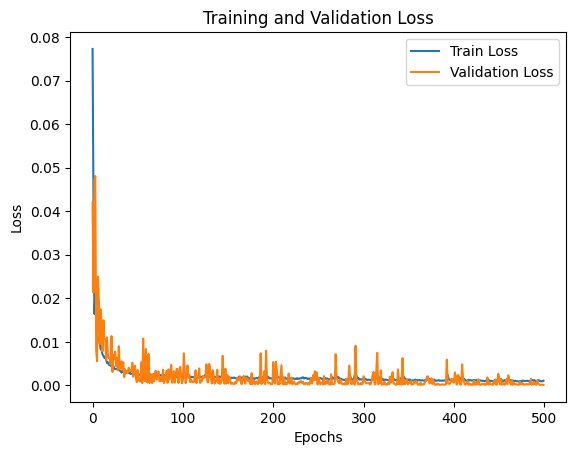

In [ ]:
# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training loss and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
def run_monte_carlo_dropout(model, X, n_samples=30):
    """
    Run Monte Carlo Dropout for making predictions.

    Parameters:
    model (keras.Model): The trained LSTM model.
    X (numpy.array): Input data for predictions.
    n_samples (int): Number of samples to draw.

    Returns:
    numpy.array: Mean predictions.
    numpy.array: Standard deviation of predictions.
    """
    predictions = np.zeros((n_samples, X.shape[0], X.shape[1]))

    for i in range(n_samples):
        predictions[i] = model.predict(X)

    mean_predictions = np.mean(predictions, axis=0)
    std_predictions = np.std(predictions, axis=0)

    return mean_predictions, std_predictions

In [ ]:
n_samples = 30  # Number of MC Dropout samples
mean_predictions, std_predictions= run_monte_carlo_dropout(model, testX, n_samples)

17/17 [==============================] - 0s 4ms/step


In [ ]:
mean_predictions = scaler.inverse_transform(mean_predictions.reshape(-1, 1)).flatten()
mean_predictions = np.exp(mean_predictions)
std_predictions = scaler.inverse_transform(std_predictions.reshape(-1, 1)).flatten()
std_predictions = np.exp(std_predictions) 

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainPredict = np.exp(trainPredict)
trainY = scaler.inverse_transform([trainY])
trainY = np.exp(trainY)
testPredict = scaler.inverse_transform(testPredict)
testPredict = np.exp(testPredict)
testY = scaler.inverse_transform([testY])
testY = np.exp(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

17/17 [==============================] - 0s 3ms/step
Train Score: 7.46 RMSE
Test Score: 22.21 RMSE


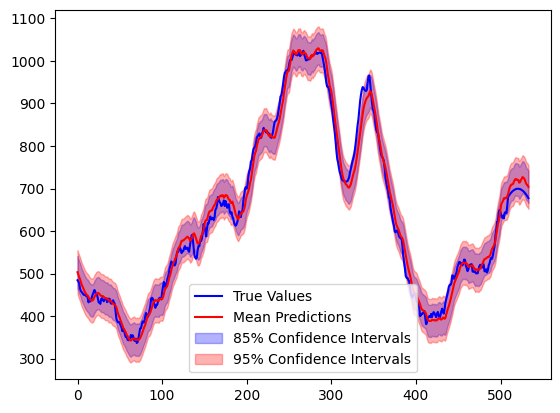

In [ ]:
# Plot original data, mean predictions, and confidence intervals
plt.plot(testY.flatten(), label='True Values', color= 'blue')
plt.plot(mean_predictions.flatten(), label='Mean Predictions', color = 'red')
plt.fill_between(
     range(len(mean_predictions.flatten())),
     mean_predictions.flatten() - 1.44 * std_predictions.flatten(),
     mean_predictions.flatten() + 1.44 * std_predictions.flatten(),
     color='blue', alpha=0.3, label='85% Confidence Intervals'
)
plt.fill_between(
     range(len(mean_predictions.flatten())),
     mean_predictions.flatten() - 1.96 * std_predictions.flatten(),
     mean_predictions.flatten() + 1.96 * std_predictions.flatten(),
     color='red', alpha=0.3, label='95% Confidence Intervals'
)
plt.legend()
plt.show()

In [ ]:
last_sequence = dataset[-look_back:]
num_predictions = 30

predicted_values = []

for _ in range(num_predictions):
    last_sequence_reshaped = np.reshape(last_sequence, (1, 1, look_back))
    predicted_value = model.predict(last_sequence_reshaped)
    predicted_values.append(predicted_value[0, 0])
    last_sequence = np.append(last_sequence[1:], predicted_value[0])

# Invert the predictions back to the original scale
predicted_values = scaler.inverse_transform([predicted_values])
predicted_values = np.exp(predicted_values)
print(predicted_values)

1/1 [==============================] - 0s 52ms/step
[[698.78736151 699.52274153 704.9831493  705.70239751 707.25134417
  710.62411131 717.86002425 723.23707562 727.48973313 732.34044828
  735.64971771 738.78324024 740.9865535  747.59355443 752.05938134
  751.67784159 757.62377705 761.93287428 770.94737362 775.06971541
  782.89927418 787.49638507 794.46205641 796.28997195 800.61827217
  805.99988292 814.09549344 816.70761029 823.24937265 824.7198631 ]]


In [ ]:
# Generate a date range for the future predictions
start_date = pandas.to_datetime(dt.index[-1]) + pandas.DateOffset(days=1)  # Assuming the last date in dt is the latest date
end_date = start_date + pandas.DateOffset(days=num_predictions-1)
future_dates = pandas.date_range(start=start_date, end=end_date)
predicted_values = np.reshape(predicted_values, (num_predictions,))
predicted_df = pandas.DataFrame(predicted_values, index=future_dates, columns=['Predicted'])
predicted_df

,Predicted
2023-04-01,698.787362
2023-04-02,699.522742
2023-04-03,704.983149
2023-04-04,705.702398
2023-04-05,707.251344
2023-04-06,710.624111
2023-04-07,717.860024
2023-04-08,723.237076
2023-04-09,727.489733
2023-04-10,732.340448


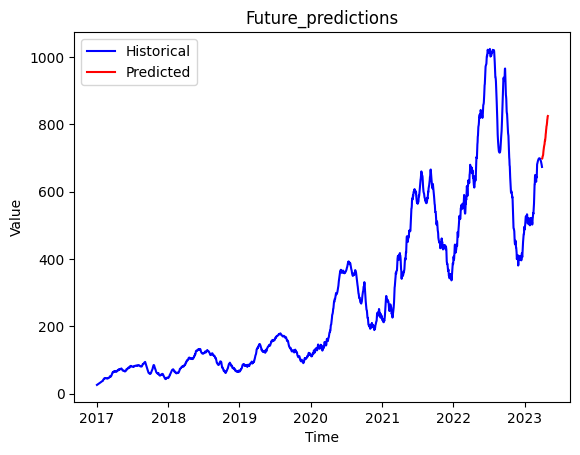

In [ ]:
plt.plot(dt.index, np.exp(filtered_data), color='blue', label='Historical')
plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Future_predictions')
plt.legend()
plt.show()

In [ ]:
#model.save('C:\\Users\\Dell\\Desktop\\best_lstm_ci.h5')
#model.save('C:\\Users\\Dell\\Desktop\\latest_lstm_CI.h5')

In [ ]:
rmse = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE:', rmse)
mape = np.mean(np.abs((testY[0] -testPredict[:,0]) / testY[0])) * 100
print('MAPE:', mape)
r2 = r2_score(testY[0], testPredict[:,0])
print('R-squared:', r2)

def mda(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_directions = np.sum(actual_direction == predicted_direction)
    mda_value = correct_directions / (len(actual_direction) - 1)
    return mda_value

mda_value = mda(testY[0], testPredict[:,0])
print('MDA:', mda_value)

RMSE: 22.214641355105506
MAPE: 2.8626942054943476
R-squared: 0.9873406670409391
MDA: 0.6729323308270677


In [ ]:
def calculate_confidence_interval(predictions, standard_error, confidence_level=0.95):
  """Calculates the confidence interval for a given set of predictions.

  Args:
    predictions: A list of predictions.
    standard_error: The standard error of the predictions.
    confidence_level: The desired confidence level.

  Returns:
    A list of confidence intervals, where each confidence interval is a tuple of
    (lower bound, upper bound).
  """

  z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
  confidence_intervals = []
  for prediction in predictions:
    lower_bound = prediction - z_score * standard_error
    upper_bound = prediction + z_score * standard_error
    confidence_intervals.append((lower_bound, upper_bound))
  return confidence_intervals

In [ ]:
std_p = np.std(predicted_values)
std_error = std_p/np.sqrt(num_predictions)
confidence_intervals = calculate_confidence_interval(predicted_values,std_error, 0.95)

In [ ]:
df = pandas.DataFrame(confidence_intervals, columns=['lower_bound', 'upper_bound'])
df.index = predicted_df.index

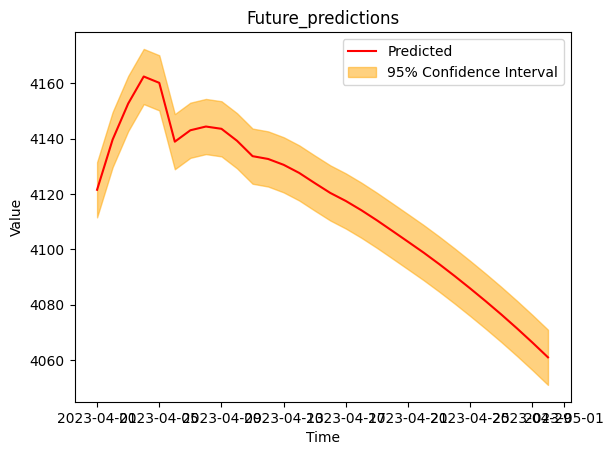

In [ ]:
#plt.plot(dt.index, np.exp(filtered_data), color='blue', label='Historical')
plt.plot(predicted_df.index, predicted_df['Predicted'], color='red', label='Predicted')
plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], color='orange', alpha=0.5, label='95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Future_predictions')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 50)                11200     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
